In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score , mean_squared_error
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("/Users/hannaholivia/Downloads/archive-2/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:xlabel='Datetime'>

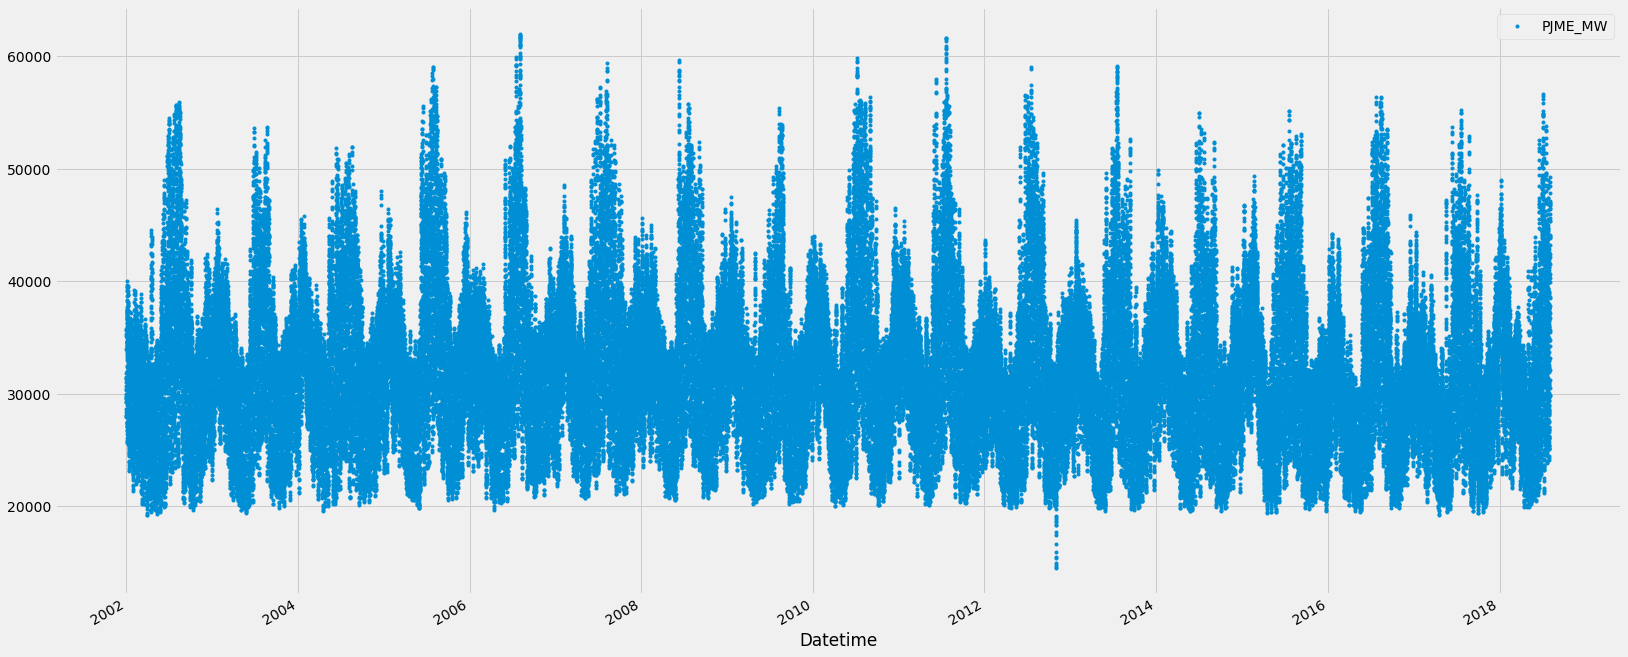

In [4]:
df.index = pd.to_datetime(df.index)
df.plot(style = "." , figsize=(25 , 12))

In [5]:
def create_features(df):
    df = df.copy()
    df["dayofmonth"] = df.index.day
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df
df = create_features(df)
df.head()

,PJME_MW,dayofmonth,month,dayofyear,weekofyear,dayofweek,hour
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,31,12,365,1,1,1
2002-12-31 02:00:00,25147.0,31,12,365,1,1,2
2002-12-31 03:00:00,24574.0,31,12,365,1,1,3
2002-12-31 04:00:00,24393.0,31,12,365,1,1,4
2002-12-31 05:00:00,24860.0,31,12,365,1,1,5


<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

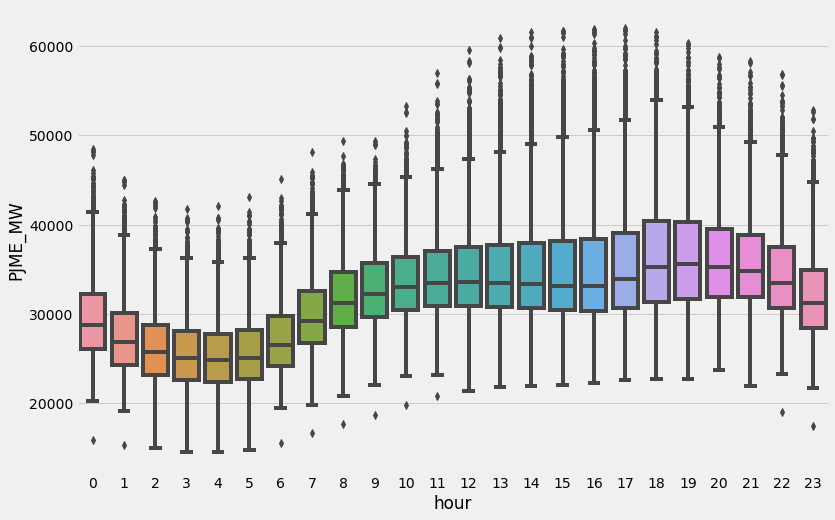

In [6]:
plt.figure(figsize = (12 , 8))
sns.boxplot(x = "hour" , y = "PJME_MW" , data = df)

<AxesSubplot:xlabel='dayofweek', ylabel='PJME_MW'>

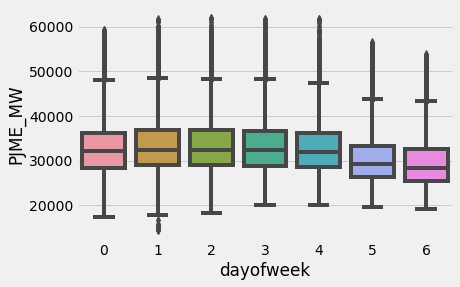

In [7]:
sns.boxplot(x = "dayofweek" , y = "PJME_MW" , data = df)

<AxesSubplot:xlabel='month', ylabel='PJME_MW'>

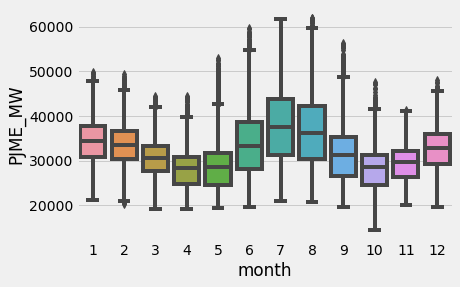

In [8]:
sns.boxplot(x = "month" , y = "PJME_MW" , data = df)

In [9]:
df = df[df["PJME_MW"] > 18000]

In [10]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index>= "01-01-2015" ]

<AxesSubplot:xlabel='Datetime'>

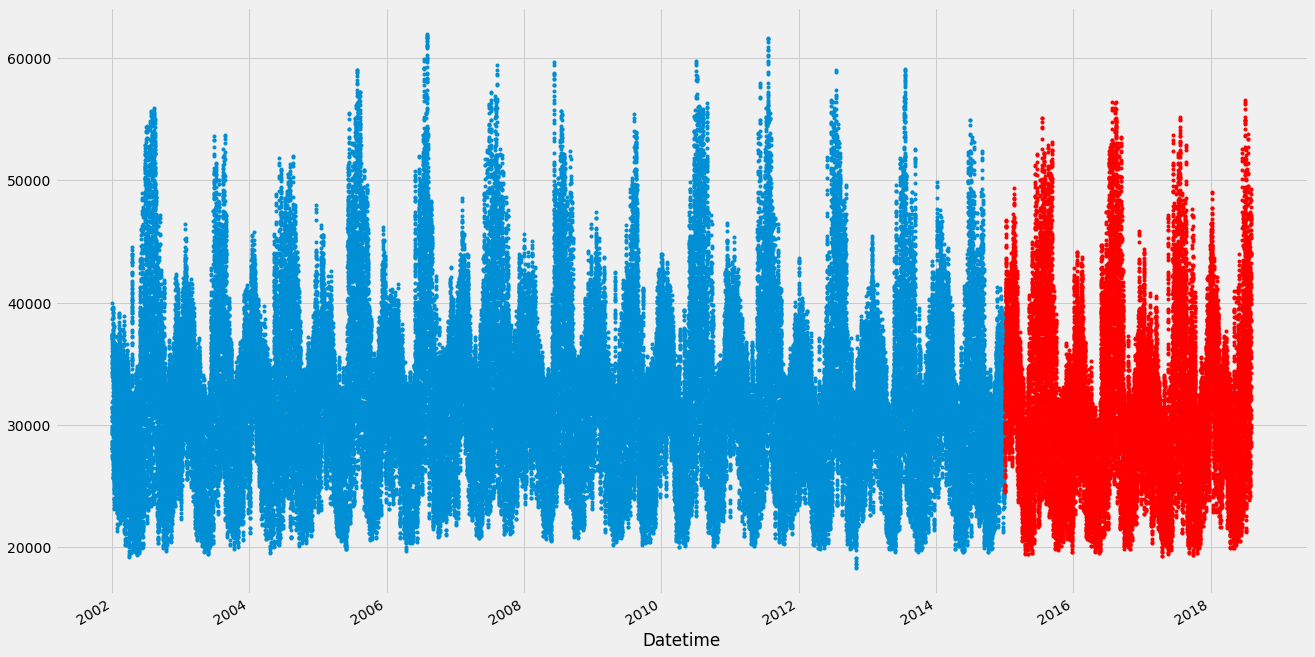

In [11]:
plt.figure(figsize = (20 , 12))
train["PJME_MW"].plot(style = "." )
test["PJME_MW"].plot(style = "." , color = "red")

In [12]:
X_train , y_train = train.drop("PJME_MW" , axis = 1) , train["PJME_MW"]
X_test , y_test = test.drop("PJME_MW" , axis = 1) , test["PJME_MW"]

In [13]:
y_test.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-12-31 01:00:00',
               '2015-12-31 02:00:00', '2015-12-31 03:00:00',
               '2015-12-31 04:00:00', '2015-12-31 05:00:00',
               '2015-12-31 06:00:00', '2015-12-31 07:00:00',
               '2015-12-31 08:00:00', '2015-12-31 09:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=31440, freq=None)

In [14]:
lr = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [15]:
lr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
pred = lr.predict(X_test)

[0]	validation_0-rmse:32606.23682	validation_1-rmse:31657.14842


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12582.98171	validation_1-rmse:11745.86571
[200]	validation_0-rmse:5836.02832	validation_1-rmse:5365.32302
[300]	validation_0-rmse:3920.89012	validation_1-rmse:3990.15293
[400]	validation_0-rmse:3465.12987	validation_1-rmse:3843.02435
[489]	validation_0-rmse:3336.89340	validation_1-rmse:3836.81753


In [16]:
np.sqrt(mean_squared_error(y_test , pred))

3835.3309971920053

In [17]:
r2_score(y_test , pred)

0.6463885144652868

In [18]:
pred = pd.DataFrame(pred , columns = ["predicted"] , index = y_test.index)
pred

,predicted
Datetime,
2015-01-01 00:00:00,30578.251953
2015-12-31 01:00:00,28016.339844
2015-12-31 02:00:00,27076.957031
2015-12-31 03:00:00,26976.898438
2015-12-31 04:00:00,26976.898438
...,...
2018-01-01 20:00:00,36590.246094
2018-01-01 21:00:00,36590.246094
2018-01-01 22:00:00,35822.164062


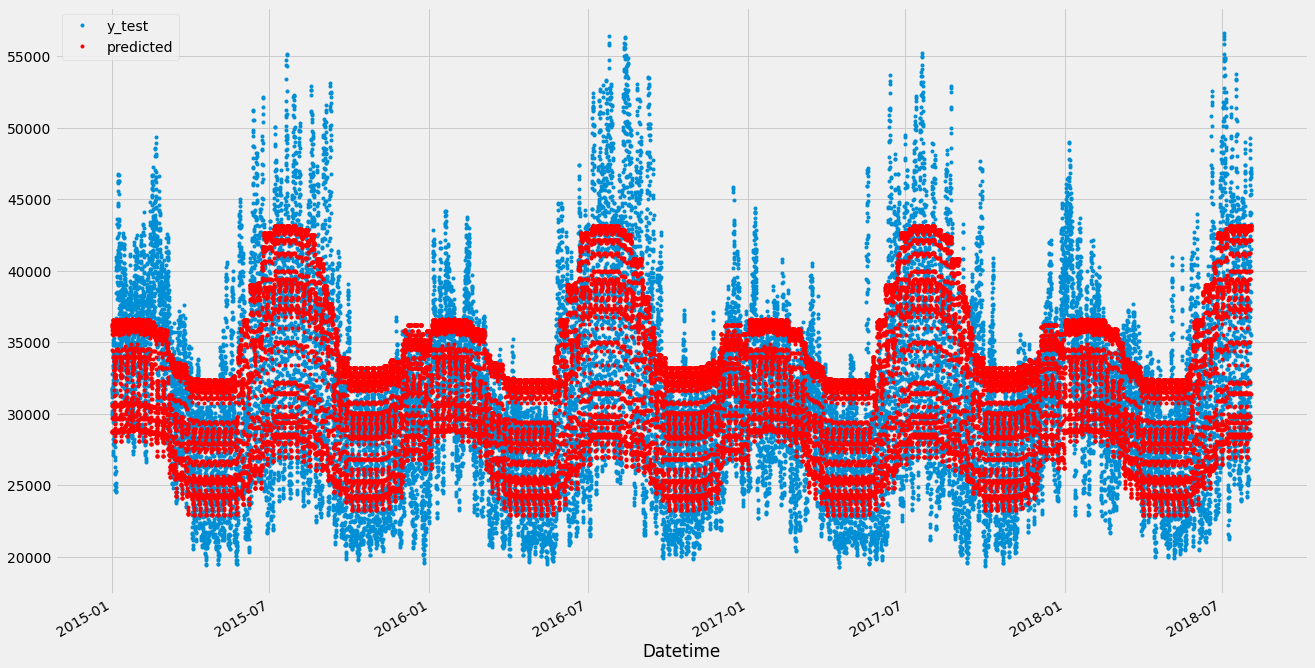

In [19]:
fig, ax = plt.subplots(figsize=(20, 12))  # Create a new figure
y_test.plot(style=".", label="y_test" , ax = ax)  # Plot y_test
pred.plot(style=".", color="red", label="pred" , ax = ax)  # Plot pred on the same axes
plt.legend()  # Add a legend to differentiate between the two plots
plt.show()  # Display the plot

<AxesSubplot:xlabel='Datetime'>

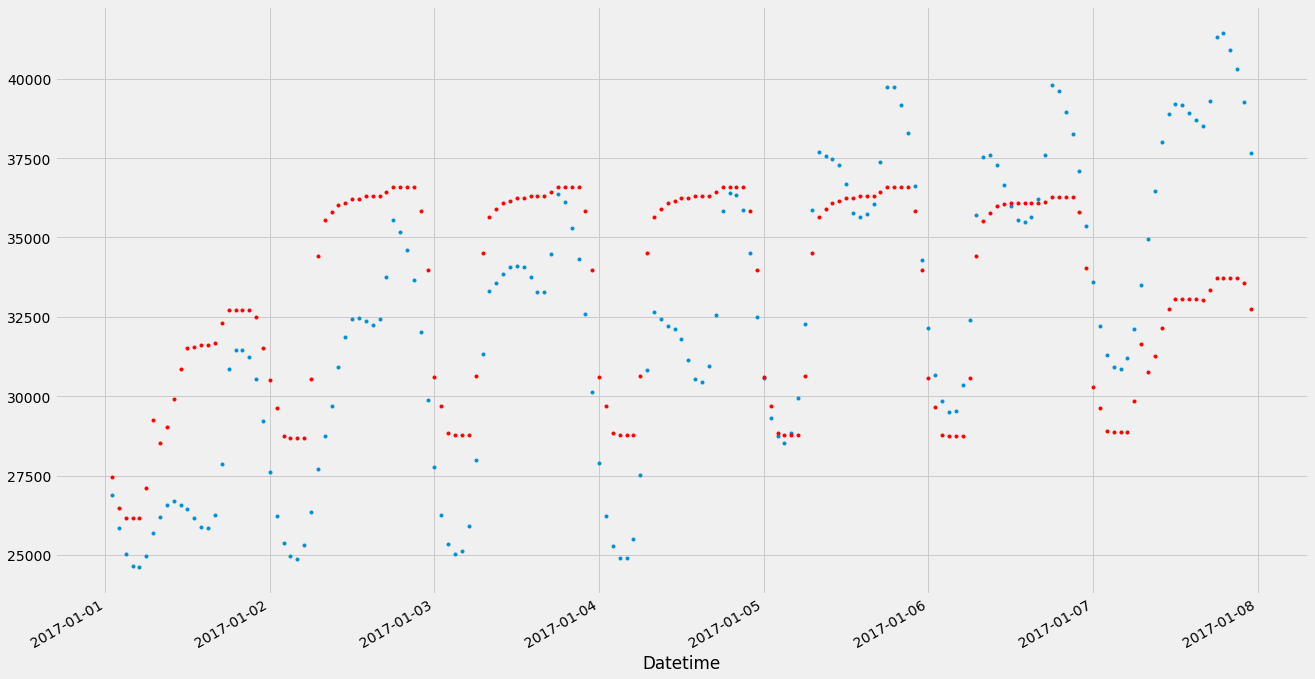

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))
df.loc[(df.index > "01-01-2017") &(df.index < "01-08-2017") ]["PJME_MW"].plot(style = "." , ax = ax)
pred.loc[(pred.index > "01-01-2017") &(pred.index < "01-08-2017") ]["predicted"].plot(style = ".", ax = ax ,color = "red")

<AxesSubplot:xlabel='Datetime'>

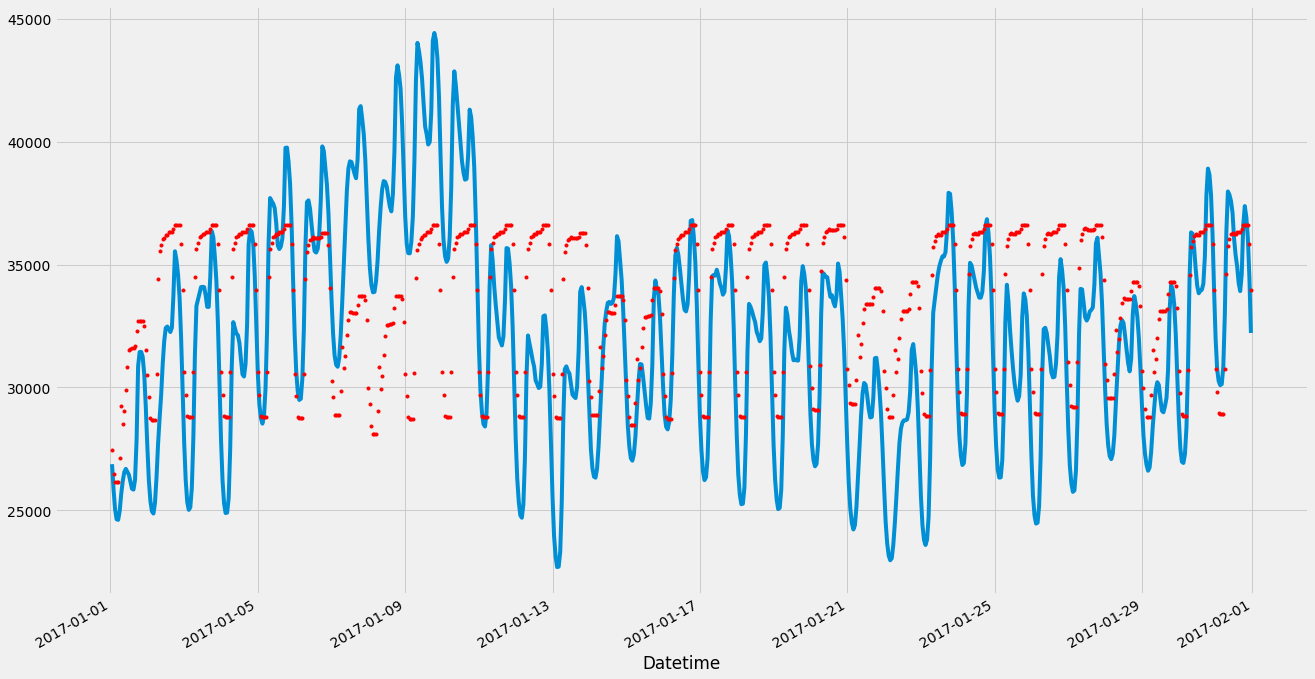

In [21]:
fig, ax = plt.subplots(figsize=(20, 12))
df.loc[(df.index > "01-01-2017") &(df.index < "02-01-2017") ]["PJME_MW"].plot( ax = ax)
pred.loc[(pred.index > "01-01-2017") &(pred.index < "02-01-2017") ]["predicted"].plot(style = ".", ax = ax ,color = "red")

In [22]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 5 , test_size = 365 *24  , gap = 24) #hours

In [23]:
df = df.sort_index()
df.head()

,PJME_MW,dayofmonth,month,dayofyear,weekofyear,dayofweek,hour
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1
2002-01-01 02:00:00,29265.0,1,1,1,1,1,2
2002-01-01 03:00:00,28357.0,1,1,1,1,1,3
2002-01-01 04:00:00,27899.0,1,1,1,1,1,4
2002-01-01 05:00:00,28057.0,1,1,1,1,1,5


In [24]:
for train_idx , val_idx in tss.split(df):    
    break
max(val_idx)

110315

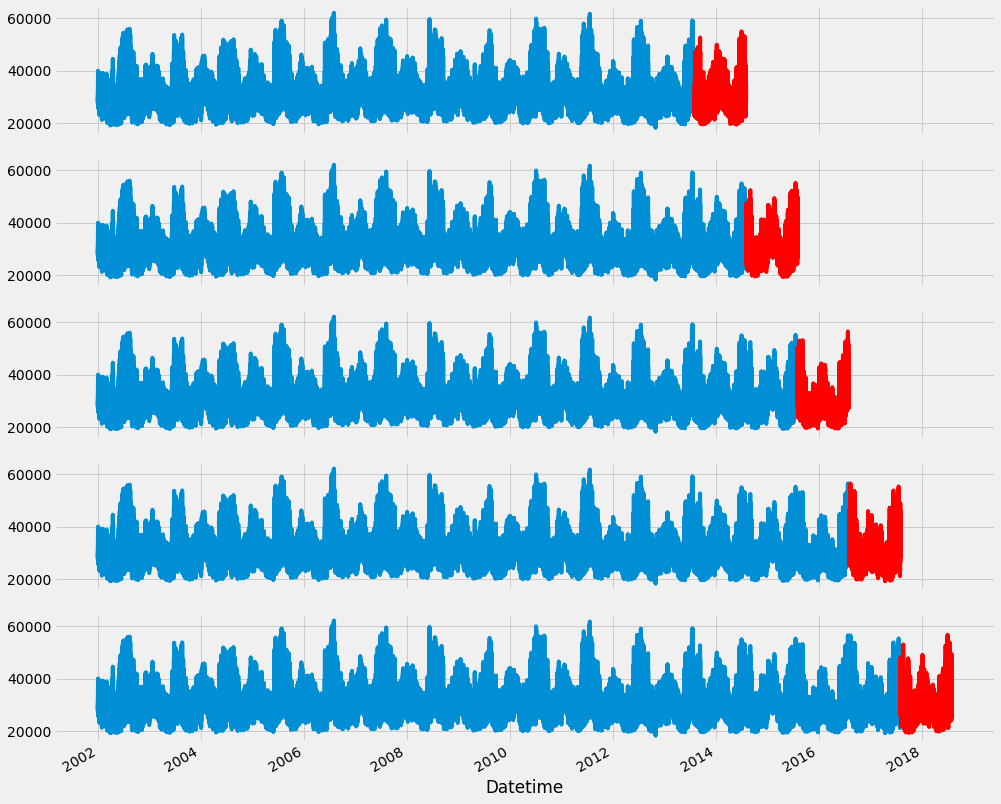

In [25]:
fig , ax = plt.subplots(5 , 1 , figsize = (15 , 15), sharex=True)
fold = 0
for train_idx , val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train["PJME_MW"].plot(ax = ax[fold] )
    val["PJME_MW"].plot(ax = ax[fold], color = "red")
    fold+=1

In [26]:
df.head()

,PJME_MW,dayofmonth,month,dayofyear,weekofyear,dayofweek,hour
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1
2002-01-01 02:00:00,29265.0,1,1,1,1,1,2
2002-01-01 03:00:00,28357.0,1,1,1,1,1,3
2002-01-01 04:00:00,27899.0,1,1,1,1,1,4
2002-01-01 05:00:00,28057.0,1,1,1,1,1,5


In [27]:
target_map = df["PJME_MW"].to_dict()

In [28]:
def add_lag(df):

    df["lag1"] = (df.index - pd.Timedelta("24 hours")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("48 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("7 hours")).map(target_map)
    
    
    return df
df_lag = add_lag(df)

In [29]:
df.head()

,PJME_MW,dayofmonth,month,dayofyear,weekofyear,dayofweek,hour,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,1,1,1,1,1,2,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,1,1,1,1,1,3,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,1,1,1,1,1,4,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,1,1,1,1,1,5,NaN,NaN,NaN


In [30]:
scores = []
for train_idx , val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train.drop("PJME_MW" , axis = 1)
    y_train = train["PJME_MW"]
    
    X_test = test.drop("PJME_MW" , axis = 1)
    y_test = test["PJME_MW"]
    
    
    lr = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.3
                         , alpha = 0.5)
    lr.fit(X_train , y_train , eval_set= [(X_train , y_train) , (X_test , y_test)] , verbose=100 )
    pred = lr.predict(X_test)
    pred_y = lr.predict(X_train)
    error = np.sqrt(mean_squared_error(y_test , pred))
    r2 = r2_score(y_test , pred)
    scores.append([error , r2 ,np.sqrt(mean_squared_error(y_train, pred_y)) ])

[0]	validation_0-rmse:23244.09899	validation_1-rmse:22634.84806


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:17:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1811.08945	validation_1-rmse:2098.73324
[200]	validation_0-rmse:1658.10924	validation_1-rmse:1961.06263
[300]	validation_0-rmse:1568.47990	validation_1-rmse:1873.34186
[400]	validation_0-rmse:1505.80201	validation_1-rmse:1823.49754
[500]	validation_0-rmse:1459.10109	validation_1-rmse:1784.13402
[600]	validation_0-rmse:1422.04926	validation_1-rmse:1766.19429
[700]	validation_0-rmse:1386.80648	validation_1-rmse:1741.05513
[800]	validation_0-rmse:1355.60020	validation_1-rmse:1708.08238
[900]	validation_0-rmse:1329.39016	validation_1-rmse:1688.30931
[999]	validation_0-rmse:1309.39844	validation_1-rmse:1680.42600
[0]	validation_0-rmse:23203.31160	validation_1-rmse:22754.21981


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:17:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1815.75454	validation_1-rmse:2067.15571
[200]	validation_0-rmse:1661.17758	validation_1-rmse:1929.88670
[300]	validation_0-rmse:1570.74934	validation_1-rmse:1850.83271
[400]	validation_0-rmse:1508.02916	validation_1-rmse:1794.90120
[500]	validation_0-rmse:1469.82874	validation_1-rmse:1767.85441
[600]	validation_0-rmse:1428.34920	validation_1-rmse:1736.05115
[700]	validation_0-rmse:1396.15138	validation_1-rmse:1715.59834
[800]	validation_0-rmse:1369.97714	validation_1-rmse:1697.62354
[900]	validation_0-rmse:1345.87102	validation_1-rmse:1684.58328
[999]	validation_0-rmse:1325.27811	validation_1-rmse:1673.85553
[0]	validation_0-rmse:23174.02101	validation_1-rmse:21936.16936


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:18:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1846.08156	validation_1-rmse:1901.64040
[200]	validation_0-rmse:1692.29421	validation_1-rmse:1779.40798
[300]	validation_0-rmse:1600.39347	validation_1-rmse:1715.93849
[400]	validation_0-rmse:1539.35241	validation_1-rmse:1669.48741
[500]	validation_0-rmse:1489.55228	validation_1-rmse:1640.32004
[600]	validation_0-rmse:1448.11715	validation_1-rmse:1616.41816
[700]	validation_0-rmse:1418.41108	validation_1-rmse:1603.19014
[800]	validation_0-rmse:1391.02438	validation_1-rmse:1593.29599
[859]	validation_0-rmse:1375.84635	validation_1-rmse:1591.25396
[0]	validation_0-rmse:23101.45238	validation_1-rmse:22313.80473


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:18:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1848.50918	validation_1-rmse:2090.92031
[200]	validation_0-rmse:1710.33978	validation_1-rmse:1967.31023
[300]	validation_0-rmse:1617.72785	validation_1-rmse:1901.64634
[400]	validation_0-rmse:1560.29918	validation_1-rmse:1863.23612
[500]	validation_0-rmse:1509.65911	validation_1-rmse:1828.37191
[600]	validation_0-rmse:1468.15161	validation_1-rmse:1800.17499
[700]	validation_0-rmse:1432.17743	validation_1-rmse:1782.14147
[800]	validation_0-rmse:1406.87634	validation_1-rmse:1769.45057
[900]	validation_0-rmse:1382.24949	validation_1-rmse:1757.25979
[999]	validation_0-rmse:1364.86354	validation_1-rmse:1749.17370
[0]	validation_0-rmse:23054.80683	validation_1-rmse:22312.96615


/Users/hannaholivia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1865.15995	validation_1-rmse:2243.53452
[200]	validation_0-rmse:1710.17417	validation_1-rmse:2112.49906
[300]	validation_0-rmse:1620.12644	validation_1-rmse:2033.16738
[400]	validation_0-rmse:1560.27243	validation_1-rmse:1990.85995
[500]	validation_0-rmse:1515.75995	validation_1-rmse:1965.22709
[600]	validation_0-rmse:1479.12669	validation_1-rmse:1946.33009
[700]	validation_0-rmse:1448.66822	validation_1-rmse:1926.12143
[800]	validation_0-rmse:1422.88475	validation_1-rmse:1913.05701
[900]	validation_0-rmse:1399.38751	validation_1-rmse:1902.43066
[982]	validation_0-rmse:1383.01564	validation_1-rmse:1896.81072


In [31]:
np.set_printoptions(suppress=True, precision=6)
np.array(scores).mean(axis = 0)

array([1717.372044,    0.925031, 1357.598528])

In [32]:
feat = pd.DataFrame(lr.feature_importances_ , index = lr.feature_names_in_ , columns = ["importance"])

<AxesSubplot:>

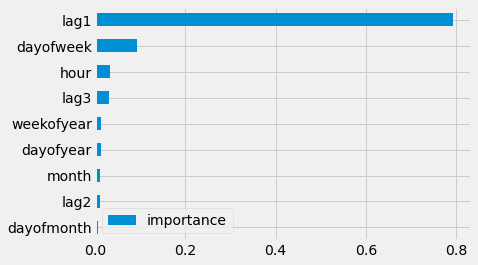

In [33]:
feat.sort_values("importance").plot(kind="barh")

In [34]:
X = df.drop("PJME_MW" , axis = 1)
y = df["PJME_MW"]

In [35]:
np.linspace(0.01 , 1 , 30)

array([0.01    , 0.044138, 0.078276, 0.112414, 0.146552, 0.18069 ,
       0.214828, 0.248966, 0.283103, 0.317241, 0.351379, 0.385517,
       0.419655, 0.453793, 0.487931, 0.522069, 0.556207, 0.590345,
       0.624483, 0.658621, 0.692759, 0.726897, 0.761034, 0.795172,
       0.82931 , 0.863448, 0.897586, 0.931724, 0.965862, 1.      ])

In [36]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import learning_curve 
train_sizes , train_scores , val_scores =  learning_curve(xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=None,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.3
                         , alpha = 0.5)
                                                          , X , y 
                                                         , cv = tss
                                                         , train_sizes = np.linspace(0.1 , 1.0 , 10) 
                                                         , scoring = "neg_root_mean_squared_error"
                                                          )

In [37]:
train_scores_m =  - train_scores.mean(axis = 1)
val_scores_m =  - val_scores.mean(axis = 1)

In [38]:
train_scores_m

array([ 646.16941 ,  897.669675, 1024.345547, 1116.592502, 1186.441245,
       1211.508593, 1232.930435, 1267.584362, 1273.074779, 1309.398439])

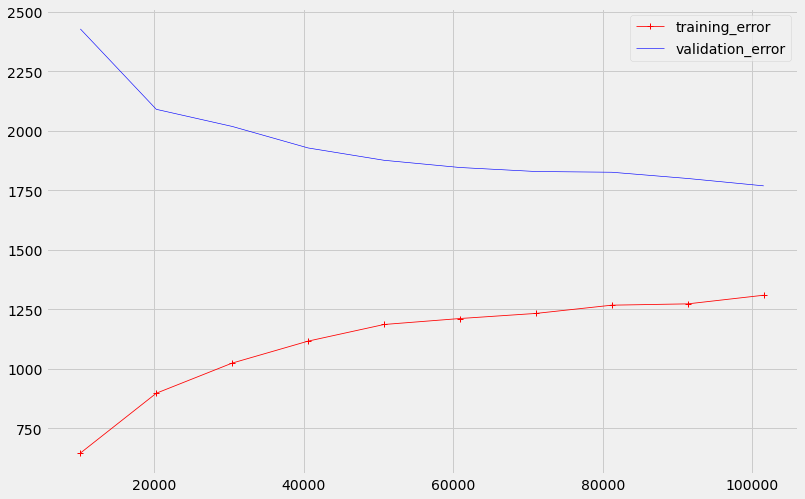

In [39]:
plt.figure(figsize = (12 , 8))
plt.plot(train_sizes , train_scores_m , "r-+" , linewidth = 0.8 , label = "training_error")
plt.plot(train_sizes , val_scores_m , "b-" , linewidth = 0.6 , label = "validation_error")
plt.legend()
plt.show()

In [40]:
train_sizes

array([ 10153,  20306,  30459,  40612,  50766,  60919,  71072,  81225,
        91378, 101532])

In [41]:
X_test , y_test = test.drop("PJME_MW" , axis = 1) , test["PJME_MW"]

In [42]:
pred = pd.DataFrame(lr.predict(X_test) , index = X_test.index , columns = ["predicted"])
pred

,predicted
Datetime,
2017-08-03 01:00:00,29716.617188
2017-08-03 02:00:00,27472.103516
2017-08-03 03:00:00,26327.796875
2017-08-03 04:00:00,25937.738281
2017-08-03 05:00:00,26298.859375
...,...
2018-08-02 20:00:00,46003.480469
2018-08-02 21:00:00,44716.750000
2018-08-02 22:00:00,42023.148438


<AxesSubplot:xlabel='Datetime'>

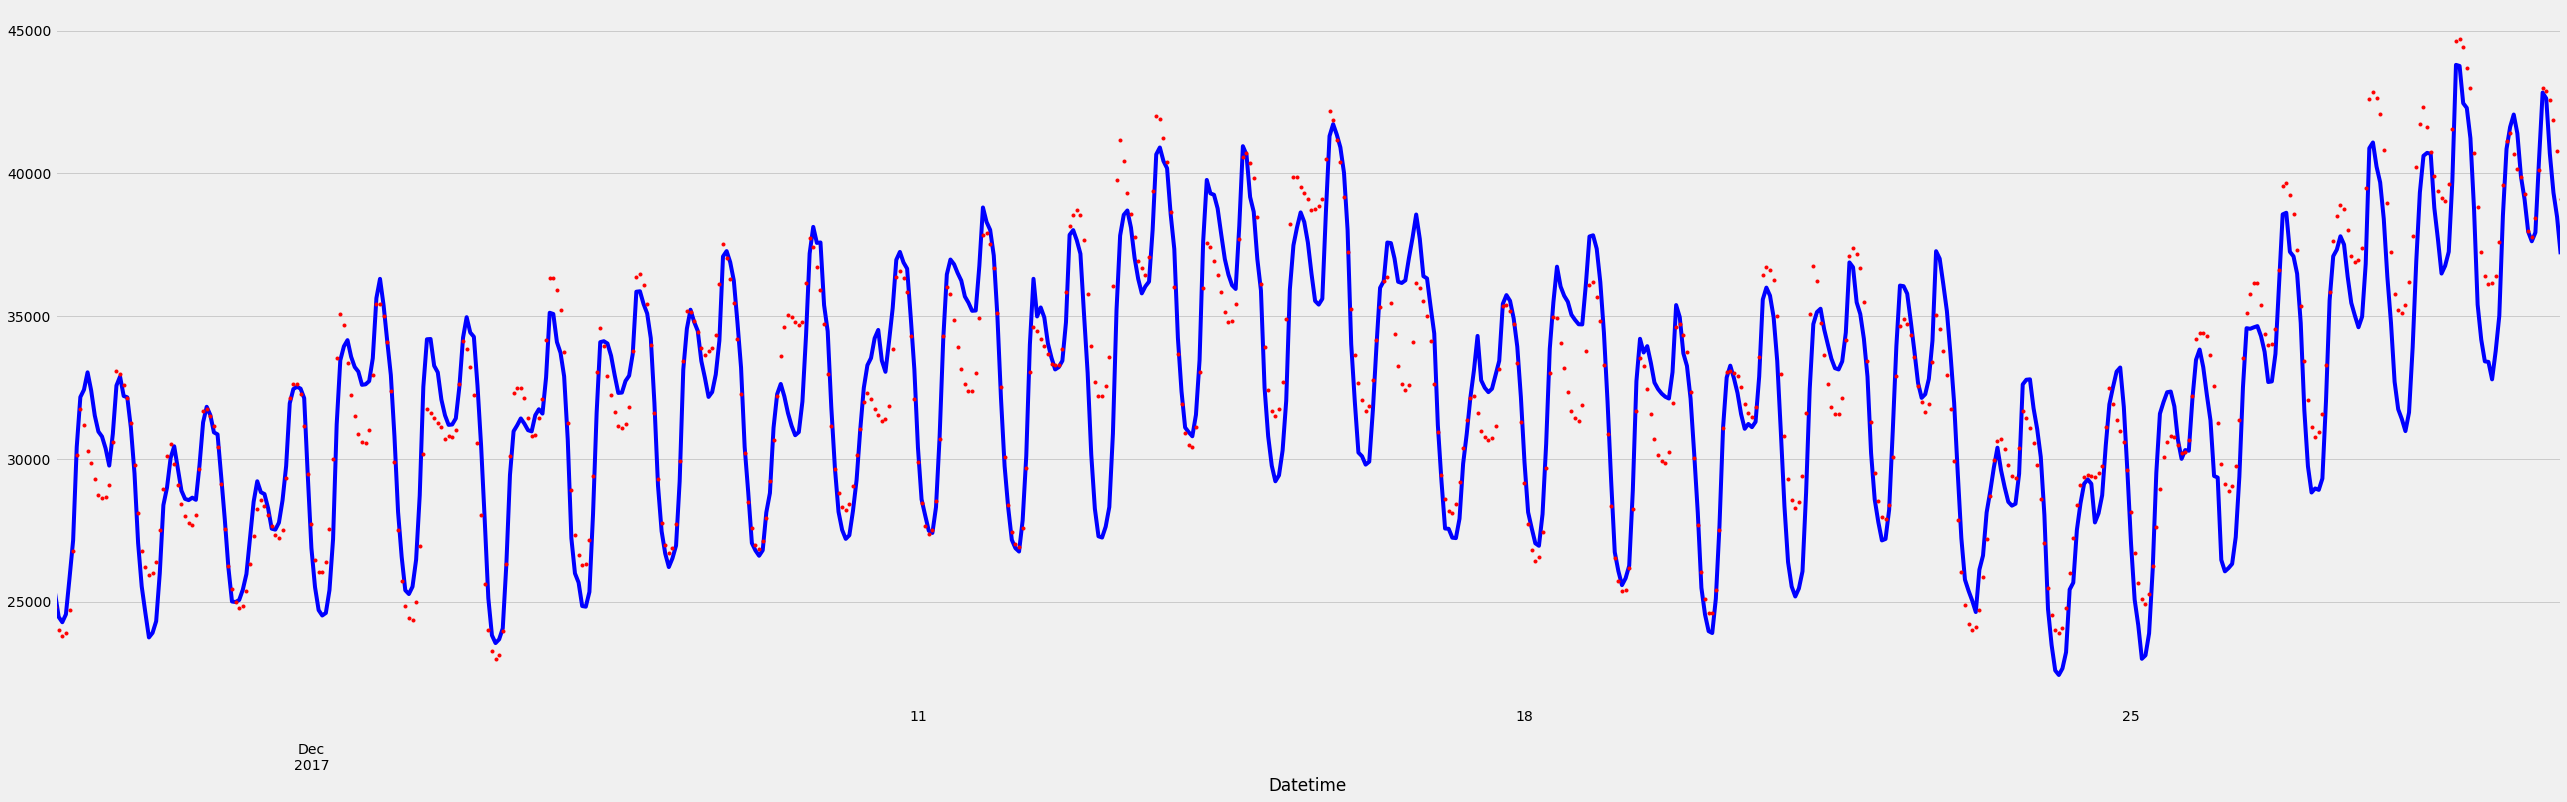

In [43]:
fig , ax = plt.subplots(figsize = (40 , 12))
pred.loc[(pred.index >"2017-12-01") & (pred.index <"2017-12-30") ]["predicted"].plot(ax = ax , color = "blue")
df.loc[(df.index >"2017-12-01") & (df.index <"2017-12-30") ]["PJME_MW"].plot( style = "." , ax = ax , color = "red")

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred, tolerance=0.1):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Custom accuracy: percentage of predictions within tolerance of true value
    accurate = np.abs(y_true - y_pred) <= (tolerance * y_true)
    accuracy = np.mean(accurate)
    
    return mse, rmse, mae, r2, accuracy

# Assume we have already split our data into train and test sets
# and trained our XGBoost model 'lr'

# Predict on training data
y_train_pred = lr.predict(X_train)

# Predict on test data
y_test_pred = lr.predict(X_test)

# Calculate metrics for training data
train_mse, train_rmse, train_mae, train_r2, train_acc = regression_metrics(y_train, y_train_pred)

# Calculate metrics for test data
test_mse, test_rmse, test_mae, test_r2, test_acc = regression_metrics(y_test, y_test_pred)

# Print results
print("Training Metrics:")
print(f"R2 Score: {train_r2:.4f}")
print(f"Accuracy (within 10%): {train_acc:.4f}")

print("\nTest Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"Accuracy (within 10%): {test_acc:.4f}")

Training Metrics:
R2 Score: 0.9539
Accuracy (within 10%): 0.9748

Test Metrics:
R2 Score: 0.9021
Accuracy (within 10%): 0.9257
